# テキストファイルをQRコード化する

* csv > 7z > base64 > v10 に収まるサイズに分割 > 複数のQRコード
  * qrcode パッケージ使用
  * テキストファイル(csv)を7zで圧縮
  * 書庫バイナリをbasae64エンコードでテキスト列にする
    * バージョン１０のQRに収まるサイズに分割
    * ヘッダ（総数、順番号）を追加
  * 分割したテキストごとのＱＲを生成 ⇒ PNGで保存
* タイル状にQRを並べた画像にする





## QRコード（モデル２）に格納可能なデータ量（バイナリ）
* 誤り訂正レベルＭ

* バージョン１０（57x57）
  * ２１３バイト（漢字１３１文字）
    * base64エンコード及びヘッダ付与の場合の実データサイズ＝１５７バイト
  * GIFサイズ：3.41 KB (3,498 バイト)
* バージョン４０（177x177）
  * ２３３１バイト（漢字１４３５文字）
   * 実データサイズ＝1746バイト
  * GIFサイズ：8.07 KB (8,264 バイト)


In [42]:
# ライブラリをインストール
#!apt install p7zip-full
!apt install graphicsmagick-imagemagick-compat
#!pip install pillow
!pip install qrcode

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphicsmagick-imagemagick-compat is already the newest version (1.4+really1.3.35-1ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
# 事前に Google Drive へ接続しておく
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# ライブラリ読み込み
import sys
print("Python Version: " + str(sys.version))
import os
import math
import subprocess
import glob
import copy
import base64

from PIL import Image
from IPython.display import Image as disp_Image
from IPython.display import display_png

import qrcode
import cv2

Python Version: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


In [45]:
## バイナリ配列をQRコードにしてPNG画像で出力する
def make_qr_png(bin_data, dst_path):
  b64bytes = base64.b64encode(bin_data).decode("ascii")
  qr = qrcode.QRCode(
          version = 10,
          error_correction = qrcode.constants.ERROR_CORRECT_M,
          box_size = 2,
          border  =2,
          )
  qr.add_data(b64bytes)
  img = qr.make_image(fill_color = "black", back_color = "white")
  img.save(dst_path)
  s = os.path.getsize(dst_path)
  sk = s / 1024
  print("{2} size: {0:,} Byte({1:.2f} KB)".format(s, sk, dst_path))
  return img

In [46]:
# 作業ディレクトリ
work_dir = "/content/drive/MyDrive/QRコード操作"

# 対象テキストファイルのサイズを調べる
target_file = os.path.join(work_dir, "meisai2", "meisai2.csv")
s = os.path.getsize(target_file)
sk = s / 1024
print("miesai2.csv size: {0:,} Byte({1:.2f} KB)".format(s, sk))

miesai2.csv size: 4,796 Byte(4.68 KB)


In [47]:
# 圧縮
arc_file = target_file + ".7z"
cmd = ["7za", "a", "-t7z", "-m0=lzma", "-mx=9", "-p0000", arc_file, target_file]
cp = subprocess.run(cmd)

s = os.path.getsize(arc_file)
sk = s / 1024
print(arc_file + " size: {0:,} Byte({1:.2f} KB)".format(s, sk))
size_arc = s

/content/drive/MyDrive/QRコード操作/meisai2/meisai2.csv.7z size: 1,106 Byte(1.08 KB)


In [48]:
# 出力先を掃除
for f in glob.glob(os.path.join(work_dir, 'output', 'qr.*.png')):
  os.remove(f)

In [49]:
# バイナリデータを分割してバージョン１０の複数のQRにする
data =""
with open(arc_file, 'br') as f:
   data = f.read()
print(f'data size: {len(data)} bytes.')

# 対象のQRバージョンに収まる実データサイズを計算する
## base64 エンコードで、サイズは 4/3 倍に増える
## 先頭2バイトにヘッダ（ファイル総数、当該ファイルシーケンス番号）を追加
QR_BYTE_MAX = 213 #V10
#QR_BYTE_MAX = 2331 #V40
HDR_SIZE = 2
B64_FACTOR = 4 / 3
# (x + 2) * 4 / 3 = 213
# (x + h) * f = max
# x + h = max / f
# x = max / f - h
SIZE_DIV_DATA = int(QR_BYTE_MAX / B64_FACTOR - HDR_SIZE)
div_count = int(math.ceil(len(data) / SIZE_DIV_DATA))
print(f"fragment size: {SIZE_DIV_DATA} bytes.")
print(f"number of fragments: {div_count}")

start_pos = 0
end_pos = start_pos + SIZE_DIV_DATA
seq = 1
total_size = 0
while start_pos < len(data):
  # ヘッダ（全数、順番号）を格納
  head = bytearray()
  head.append(div_count)
  head.append(seq)
  print(f'head: {head}')

  # ヘッダの後ろに分割データを連結
  sdat = bytes(data[start_pos:end_pos])
  total_size += len(sdat)
  print(f'data slice: {sdat}')
  qr_data = bytes(head) + sdat
  # 注意：バイト配列(bytes)にしてから引き渡すこと！
  # bytearrayが混在したデータだと正しいQRにならない
  print(f"# {seq}/{div_count}: {len(qr_data)} bytes [{qr_data}]")
  qr_name = "qr." + "{0:03}".format(seq) + ".png"
  qr_png = os.path.join(work_dir, "output", qr_name)

  # QR 生成
  make_qr_png(qr_data, qr_png)
  
  # データ分割位置を更新
  start_pos += SIZE_DIV_DATA
  end_pos = start_pos + SIZE_DIV_DATA
  seq += 1

print(f'total size: {total_size}')

data size: 1106 bytes.
fragment size: 157 bytes.
number of fragments: 8
head: bytearray(b'\x08\x01')
data slice: b"7z\xbc\xaf'\x1c\x00\x04\x90\x11\xd0d\xc0\x03\x00\x00\x00\x00\x00\x00r\x00\x00\x00\x00\x00\x00\x00<@8\x171D5`d6:\xb53|L>`\xf4\x00=\x13^\x96\xf66\xcf\xc0a\xad\xfc\xf5(\xee\xe4\xee\xc7\x80\xf1\x9a\xd5\n\xaa\xa9vx\x17^\x16a\xc0\x19k\xec,\x1b\xb7\xfc\xc2'\x952yJ\xda\xa9\x06\xb7G\xdd\xcd-\xb07\xd7r\xb3!\x19D<cGrh\xc0\xed0\xc0LU\xd4\xaa&\xe0\xfc\xbbP0_z\xef\\\xd5\xe1\x1a\xd0\xe6\x19(\xcc\xd4;\x08*tB\x14\x8d\x8f\xc3\x08zxj\xa0\xe3\xce\xdbB"
# 1/8: 159 bytes [b"\x08\x017z\xbc\xaf'\x1c\x00\x04\x90\x11\xd0d\xc0\x03\x00\x00\x00\x00\x00\x00r\x00\x00\x00\x00\x00\x00\x00<@8\x171D5`d6:\xb53|L>`\xf4\x00=\x13^\x96\xf66\xcf\xc0a\xad\xfc\xf5(\xee\xe4\xee\xc7\x80\xf1\x9a\xd5\n\xaa\xa9vx\x17^\x16a\xc0\x19k\xec,\x1b\xb7\xfc\xc2'\x952yJ\xda\xa9\x06\xb7G\xdd\xcd-\xb07\xd7r\xb3!\x19D<cGrh\xc0\xed0\xc0LU\xd4\xaa&\xe0\xfc\xbbP0_z\xef\\\xd5\xe1\x1a\xd0\xe6\x19(\xcc\xd4;\x08*tB\x14\x8d\x8f\xc3\x08zxj\x

/content/drive/MyDrive/QRコード操作/output/qr.001.png


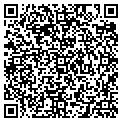

/content/drive/MyDrive/QRコード操作/output/qr.002.png


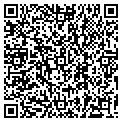

/content/drive/MyDrive/QRコード操作/output/qr.003.png


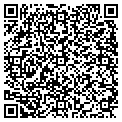

/content/drive/MyDrive/QRコード操作/output/qr.004.png


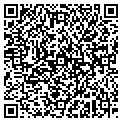

/content/drive/MyDrive/QRコード操作/output/qr.005.png


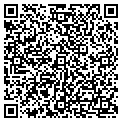

/content/drive/MyDrive/QRコード操作/output/qr.006.png


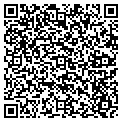

/content/drive/MyDrive/QRコード操作/output/qr.007.png


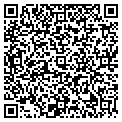

/content/drive/MyDrive/QRコード操作/output/qr.008.png


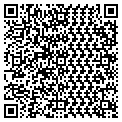

In [50]:
# 生成したQRパスををソートしてリストに格納
# リストからPNG表示
from pathlib import Path
out_dir = os.path.join(work_dir, 'output')
png_list = sorted(Path(out_dir).glob("qr.*.png"))
for png in png_list:
  print(png)
  display_png(disp_Image(png))

In [51]:
# パディング用の空画像を（先頭画像のサイズで）作成
png0 = str(png_list[0])
img0 = Image.open(png0)
img = Image.new(mode = "L", size = img0.size, color = 255)
png_none = os.path.join(work_dir, "none.png")
img.save(png_none)
#print(png_none)
#display_png(disp_Image(png_none))

In [52]:
# 画像を連結して1枚にする
# 4列、ｎ行
COL = 4

# リスト末尾に4列にちょうど収まるように空白画像を追加する
png_pad_list = copy.deepcopy(png_list)
mod = len(png_pad_list) % COL
for i in range(len(png_pad_list) % COL):
  png_pad_list.append(Path(png_none))

/content/drive/MyDrive/QRコード操作/qr.tile.png
size: 19,215 Byte(18.76 KB)


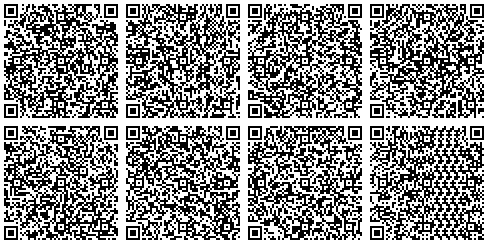

/content/drive/MyDrive/QRコード操作/qr.tile.1.png
size: 4,059 Byte(3.96 KB)


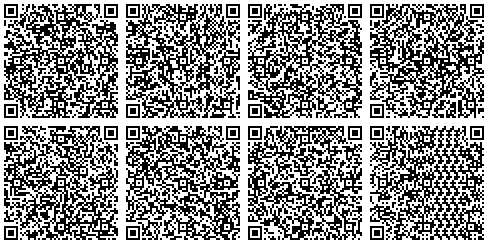

/content/drive/MyDrive/QRコード操作/qr.tile.gif
size: 12,077 Byte(11.79 KB)


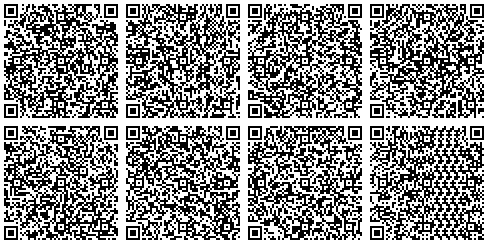

/content/drive/MyDrive/QRコード操作/qr.tile.gm.gif
size: 10,797 Byte(10.54 KB)


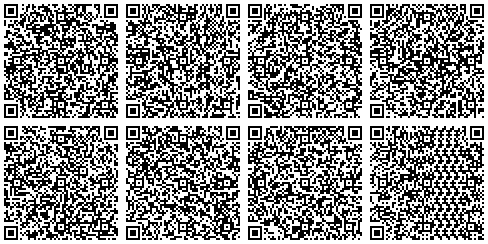

In [56]:
# 画像を読み込み、COL 列の2次元配列に格納する
if len(png_list) > 1:
  img_2d = []
  n_line = int(len(png_pad_list) / COL)
  for i in range(n_line):
    png = str(png_pad_list[i * COL])
    img = cv2.imread(png)
    img_line = []
    img_line.append(img)
    for j in range(1, COL):
      png = str(png_pad_list[i * COL + j])
      img = cv2.imread(png)
      img_line.append(img)
    img_2d.append(img_line)

  # 画像を連結
  img_tile = cv2.vconcat([cv2.hconcat(img_line) for img_line in img_2d])

  # 8bitカラーになっているっぽいのでグレースケールにする
  img_gray = cv2.cvtColor(img_tile, cv2.COLOR_BGR2GRAY)
  # ２値化
  th, img_tile = cv2.threshold(img_gray, 128, 255, cv2.THRESH_BINARY)

  # 保存、表示(8bit)
  png_tile = os.path.join(work_dir, "qr.tile.png")
  cv2.imwrite(png_tile, img_tile)
  print(png_tile)
  s = os.path.getsize(png_tile)
  sk = s / 1024
  print("size: {0:,} Byte({1:.2f} KB)".format(s, sk))
  display_png(disp_Image(png_tile))

  # １ビットに変換・保存
  img = Image.open(png_tile)
  img1 = img.convert("1")
  png1 = os.path.join(work_dir, "qr.tile.1.png")
  img1.save(png1)
  print(png1)
  s = os.path.getsize(png1)
  sk = s / 1024
  print("size: {0:,} Byte({1:.2f} KB)".format(s, sk))
  display_png(disp_Image(png1))
 
  # GIF(8bit)で保存
  gif1 = os.path.join(work_dir, "qr.tile.gif")
  img1.save(gif1)
  print(gif1)
  s = os.path.getsize(gif1)
  sk = s / 1024
  print("size: {0:,} Byte({1:.2f} KB)".format(s, sk))
  display(disp_Image(gif1))

# convertコマンド（ImageMagic fork の graphicsmagick を使う）
# こちらのほうが若干小さくなる
gif2 = os.path.join(work_dir, "qr.tile.gm.gif")
cmd = ["convert", png_tile, "-depth", "1",  gif2]
subprocess.run(cmd)
print(gif2)
s = os.path.getsize(gif2)
sk = s / 1024
print("size: {0:,} Byte({1:.2f} KB)".format(s, sk))
display(disp_Image(gif2))